<a href="https://colab.research.google.com/github/ioan-hedea/deepLearning4005/blob/main/Assignment_6(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning - Assignment 6**

*These lab assignments are new in the Machine and Deep Learning course. We'd like to hear what you think!*

*Please post any feedback you have on Brightspace. Thanks!*


---

## Introduction - Evaluation in Machine Learning

In this assignment, you will learn about common evaluation techniques in machine learning. This includes evaluating the error of the classifier, analyzing the learning curves, and performing cross-validation.

**Prerequisites:**
* Basic working knowledge of multivariate statistics and linear algebra
* Basic knowledge of Python and Numpy. Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).

**Learning objectives:**
* Can explain what sources of performance variability there are in machine learning
* Knowing what a learning curve is
* Can understand the difference between train and test error
* Can explain what cross-validation is and how it is used

**Exercises types:**
* **Pen \& Paper** - Some exercises will ask you to write down mathematical derivations, calculations, explanations, or simple plots and representations. You can perform these exercises on paper or using a LaTeX editor.
* **Coding** - Some exercises will ask you to write Python code.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

---

## 1 - Sources of Variation (**Coding**)

### **Exercise 1.1**

In this exercise we investigate the difference in behavior of the error on the training and the test set. Generate a large test set and study the variations in the classification error based on repeatedly generated training sets. Use one of the artificial datasets from the first week's assignment.

Train error: mean=0.051  std=0.016
Test  error: mean=0.064  std=0.004


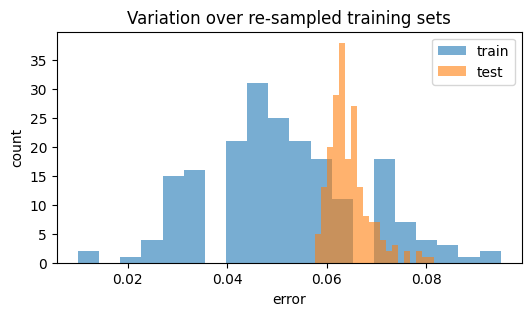

In [7]:
# Exercise 1.1 — train/test error variability from re-sampled training sets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss

rng = np.random.RandomState(42)

# Big fixed test set for a low-variance estimate of "true" error
X_all, y_all = make_moons(n_samples=200000, noise=0.25, random_state=0)
X_test, y_test = X_all, y_all   # treat as the population test set

def run_once(m_train=200, k=5):
    # re-draw a *fresh* training set each time
    X, y = make_moons(n_samples=m_train, noise=0.25, random_state=rng.randint(1_000_000))
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    err_train = zero_one_loss(y, clf.predict(X))
    err_test  = zero_one_loss(y_test, clf.predict(X_test))
    return err_train, err_test

R = 200   # repetitions
errs_tr, errs_te = zip(*[run_once(m_train=200, k=5) for _ in range(R)])
errs_tr, errs_te = np.array(errs_tr), np.array(errs_te)

print(f"Train error: mean={errs_tr.mean():.3f}  std={errs_tr.std():.3f}")
print(f"Test  error: mean={errs_te.mean():.3f}  std={errs_te.std():.3f}")

figsize = (6, 3)
plt.figure(figsize=figsize)

plt.hist(errs_tr, bins=20, alpha=0.6, label="train")
plt.hist(errs_te, bins=20, alpha=0.6, label="test")
plt.xlabel("error"); plt.ylabel("count"); plt.legend(); plt.title("Variation over re-sampled training sets")
plt.show()

#### (a) What causes the variation in the error?

Now do the same for different test sets:

In [8]:
# Re-draw both training and test sets each repetition
def run_both(m_train=200, m_test=5000, k=5):
    Xtr, ytr = make_moons(n_samples=m_train, noise=0.25, random_state=rng.randint(1_000_000))
    Xte, yte = make_moons(n_samples=m_test,  noise=0.25, random_state=rng.randint(1_000_000))
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(Xtr, ytr)
    err_train = zero_one_loss(ytr, clf.predict(Xtr))
    err_test  = zero_one_loss(yte, clf.predict(Xte))
    return err_train, err_test

R = 200
errs_tr2, errs_te2 = zip(*[run_both() for _ in range(R)])
errs_tr2, errs_te2 = np.array(errs_tr2), np.array(errs_te2)

print(f"[Both vary] Train mean={errs_tr2.mean():.3f} std={errs_tr2.std():.3f}")
print(f"[Both vary] Test  mean={errs_te2.mean():.3f} std={errs_te2.std():.3f}")

[Both vary] Train mean=0.049 std=0.014
[Both vary] Test  mean=0.066 std=0.005


#### (b) Again explain what causes the variance observed in the results.

---

## 2 - Learning Curves (**Coding**)

### **Exercise 2.1**

Using prtools lib, generate Highleyman classes (gendath) with a 1000 samples per class. Enlarge the feature dimensionality of this set by adding 60 dimensions of class independent randomness, i.e., plain noise. After that, use the function pr.cleval to generate learning curves for nmc, ldc, and qdc using 64, 128, 256, and 512 objects in the training set (make sure that you repeat often enough. . . ). Note that cleval automatically plots the learning curves.

In [ ]:
%pip install --no-cache-dir --force-reinstall git+https://github.com/DMJTax/prtools.git#egg=prtools
import prtools as pr

#### (a) Can you explain the overall behavior of these curves?

#### (b) Explain why the curves intersect. Which classifier performs best?

#### (c) What do you expect the limiting behavior of learning curves is? That is, if we were able to   train on more and more data?

---

## 3 - Cross-Validation (**Coding**)

### **Exercise 3.1**

Generate a small data set, say, with 10 objects per class.

In [9]:
from sklearn.datasets import make_blobs
X_small, y_small = make_blobs(n_samples=20, centers=2, cluster_std=1.2, random_state=1)  # 10 per class

#### (a) Using n-fold cross-validation,make plots for the error rates for kNN and 1NN over different values of n. Also calculate the standard deviation of the error estimate, e.g., by performing the cross-validation 10 times

In [11]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import zero_one_loss

def cv_errors(X, y, n_splits, k, repeats=10, seed=0):
    rng = np.random.RandomState(seed)
    errs = []
    for r in range(repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng.randint(1_000_000))
        fold_errs = []
        for tr, te in skf.split(X, y):
            clf = KNeighborsClassifier(n_neighbors=k)
            clf.fit(X[tr], y[tr])
            fold_errs.append(zero_one_loss(y[te], clf.predict(X[te])))
        errs.append(np.mean(fold_errs))
    return np.mean(errs), np.std(errs)

ns = [2, 5, 10]  # different n-fold values (with 20 samples, 10-fold is LOOCV per class)
rows = []
for n in ns:
    m1, s1 = cv_errors(X_small, y_small, n_splits=n, k=1)
    m5, s5 = cv_errors(X_small, y_small, n_splits=n, k=5)
    rows.append((n, m1, s1, m5, s5))

print("n_splits | 1NN mean±std | 5NN mean±std")
for n, m1, s1, m5, s5 in rows:
    print(f"{n:8d} | {m1:.3f}±{s1:.3f} | {m5:.3f}±{s5:.3f}")

n_splits | 1NN mean±std | 5NN mean±std
       2 | 0.000±0.000 | 0.000±0.000
       5 | 0.000±0.000 | 0.000±0.000
      10 | 0.000±0.000 | 0.000±0.000


#### (b) What do you notice about the estimated error rates? What is the general trend (maybe you should redo the data generation and the cross-validation a couple of times).

#### (c) What happens to the variance of the estimates for varying n? Again, we are interested in the general trend.

#### (d) How would the observations change if one would repeat the experiments with much larger dataset? Would they change?